In [1]:
import numpy as np
import pandas as pd
import mne
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from lightgbm import LGBMClassifier
import lightgbm
from scipy.stats import zscore
import xgboost as xgb
from visbrain.io.rw_hypno import read_hypno
from ipynb.fs.defs.yasa_model import calc_features, get_metrics
import joblib
from IPython.display import clear_output
from sklearn.feature_selection import VarianceThreshold
plt.style.use('dark_background')
pd.options.display.precision = 10

In [2]:
# joblib_file = 'lgbm_model_multichannel.pkl'
# model = joblib.load(joblib_file)
model = joblib.load('forest_full.pkl')
features_names = pd.read_csv('features_forest.csv').columns.tolist()

In [3]:
####################
# MAIN PARAMETERS
####################

# # Bandpass filter
# freq_broad = (0.1, 500)
# # FFT & bandpower parameters
sr = 1000
# bands = [
#     (0.1, 4, 'delta'), (4, 8, 'theta'),
#     (8, 12, 'alpha'), (12, 16, 'sigma'), (16, 30, 'beta'),
#     (30, 75, 'gamma'), (75, 300, 'fast')
# ]

In [4]:
def remove_rem(raw, edf):
    hypno_file = edf.split('_')[0] + '_hypno.txt'

    # read hypnogram old format (1sec)
    hypno, sf_hypno = read_hypno(hypno_file, time=None, datafile=None)

    # make raw object into epochs (30 sec)
    dummy_events = mne.make_fixed_length_events(raw, id=1, duration=30)[:len(hypno)]

    # incorporate the scoring into the events file:
    dummy_events[:, 2] = hypno
    event_dict = {'W': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'REM': 4, 'art': -1}

    # epoch data into 30sec pieces:
    epochs = mne.Epochs(raw, events=dummy_events, event_id=event_dict, tmin=0,
                        tmax=30, baseline=(0, 0), on_missing='ignore')
    epochs.drop(epochs['REM'].selection)
    nrem_raw = mne.io.RawArray(np.concatenate(epochs.get_data(), axis=1), raw.info)

    return nrem_raw

def format_raw_night(edf, channel):
    epochs = []
    window_size = int(sr / 4)
    if '-' in channel and 'REF' not in channel:
        chans = channel.split('-')
        raw = mne.io.read_raw_edf(edf).pick_channels(chans).resample(sr)
        # raw = remove_rem(raw, edf)
        mne.set_bipolar_reference(raw, chans[0], chans[1], ch_name=channel)
        raw_data = raw.get_data()[0]
    else:
        raw_data = mne.io.read_raw_edf(edf).pick_channels([channel]).resample(sr).get_data()[0]
    for i in range(0, len(raw_data), window_size):
        curr_block = raw_data[i: i  + window_size]
        if i + window_size < len(raw_data):
            epochs.append(curr_block)
    return np.array(epochs)
    # return zscore(np.array(epochs))

def get_y_bilateral(subj, channel):
    x_right = format_raw_night(f'C:\\UCLA\\{subj}_cz+bi_full_filtered.edf', 'R' + channel)
    feat_right = calc_features(x_right, subj)
    y_right = model.predict(feat_right[features_names[1:]])

    x_left = format_raw_night(f'C:\\UCLA\\{subj}_cz+bi_full_filtered.edf', 'L' + channel)
    feat_left = calc_features(x_left, subj)
    y_left = model.predict(feat_left[features_names[1:]])
    y_all = y_right + y_left
    y_all[y_all == 2] = 1
    return y_all

# TODO: debug again!
def get_y_bi_prob(subj, channel):
    x_right = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', channel)
    feat_right = calc_features(x_right, subj)
    y_right_prob = model.predict_proba(feat_right[features_names[1:]]).T
    y_right = [1 if p > 0.85 else 0 for p in y_right_prob[1]]

    x_left = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', channel)
    feat_left = calc_features(x_left, subj)
    y_left_prob = model.predict_proba(feat_left[features_names[1:]]).T
    y_left = [1 if p > 0.85 else 0 for p in y_left_prob[1]]
    y_all = y_right + y_left
    y_all[y_all == 2] = 1
    return y_all

In [49]:
def get_all_y_multi_channel(subjects=['396', '398', '402', '406', '415', '416']):
    neighbors = {'R': ['RAH1-RAH2', 'RA1'], 'L': ['LAH1-LAH2', 'LA1']}
    side1_y = None
    y_all = np.empty(0)
    for subj in subjects:
        # for subj in ['398']:
        for channel in ['RAH1', 'LAH1']:
            if not (subj == '396' and channel == 'RAH1'):
                x = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', channel)
                features = calc_features(x, subj)
                for neighbor in neighbors[channel[0]]:
                    x_neighbor = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', neighbor)
                    prefix = neighbor.replace(channel[0], '')
                    features_neighbor = calc_features(x_neighbor, subj).add_prefix(f'{prefix}_')
                    features = pd.concat([features, features_neighbor.iloc[:, 2:]], axis=1)

                # Here I have all features for one side
                if side1_y is None:
                    side1_y = model.predict(features[features_names[1:]])

        if subj == '396':
            y_all = np.concatenate((y_all, side1_y))
        else:
            side2_y = model.predict(features[features_names[1:]])
            y_bilateral = side1_y + side2_y
            y_bilateral[y_bilateral == 2] = 1
            y_all = np.concatenate((y_all, y_bilateral))

        side1_y = None

    return y_all

def get_all_y_multi_channel_side(side, subjects=['396', '398', '402', '406', '415', '416']):
    neighbors = {'R': ['RAH1-RAH2', 'RA1'], 'L': ['LAH1-LAH2', 'LA1']}
    y_all = np.empty(0)
    for subj in subjects:
        channel = side + 'AH1'
        if not (subj == '396' and channel == 'RAH1'):
            x = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', channel)
            features = calc_features(x, subj)
            for neighbor in neighbors[channel[0]]:
                x_neighbor = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', neighbor)
                prefix = neighbor.replace(channel[0], '')
                features_neighbor = calc_features(x_neighbor, subj).add_prefix(f'{prefix}_')
                features = pd.concat([features, features_neighbor.iloc[:, 2:]], axis=1)

            side1_y = model.predict(features[features_names[1:]])
            y_all = np.concatenate((y_all, side1_y))

    return y_all

def get_one_y_multi_channel_side(subj, side):
    neighbors = {'R': ['RAH1-RAH2', 'RA1'], 'L': ['LAH1-LAH2', 'LA1']}
    channel = side + 'AH1'
    if not (subj == '396' and channel == 'RAH1'):
        x = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', channel)
        features = calc_features(x, subj)
        for neighbor in neighbors[channel[0]]:
            x_neighbor = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', neighbor)
            prefix = neighbor.replace(channel[0], '')
            features_neighbor = calc_features(x_neighbor, subj).add_prefix(f'{prefix}_')
            features = pd.concat([features, features_neighbor.iloc[:, 2:]], axis=1)

        side1_y = model.predict(features[features_names[1:]])

    return side1_y

def get_all_feat_eog(eog_num, subjects=['396', '398', '402', '406', '415', '416']):
    feat_all = pd.DataFrame()
    for subj in subjects:
        x = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', 'EOG' + eog_num)
        features = calc_features(x, subj)
        # normalize each subject with respect to self
        # features=(features-features.mean())/features.std()
        # features.apply(zscore)
        feat_all = pd.concat([feat_all, features], axis=0)

    return feat_all

def get_all_feat_channels(channels=['C3', 'C4', 'PZ'], subjects=['396', '398', '402', '406', '415', '416']):
    feat_all = pd.DataFrame()
    for subj in subjects:
        channel = channels[0]
        x = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', channel)
        features = calc_features(x, subj)
        for neighbor in channels[1:]:
            x_neighbor = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', neighbor)
            prefix = neighbor.replace(channel[0], '')
            features_neighbor = calc_features(x_neighbor, subj).add_prefix(f'{prefix}_')
            features = pd.concat([features, features_neighbor.iloc[:, 2:]], axis=1)

        feat_all = pd.concat([feat_all, features], axis=0)

    return feat_all

In [6]:
# y_406_bi = get_y_bilateral('406', 'AH')
# y_402_bi = get_y_bilateral('402', )

In [21]:
# y_406_bi_prob = get_y_bi_prob('406')
# y_402_bi_prob = get_y_bi_prob('402')

In [7]:
# y_all_bi = get_all_y_multi_channel()
y_all_bi = np.load('y_all_ff_bi.npy')
clear_output()

In [146]:
y_5_bi = get_all_y_multi_channel()
feat_5_eog1 = get_all_feat_eog('1')
feat_5_eog2 = get_all_feat_eog('2')
feat_5_eog_bi = pd.concat([feat_5_eog1.add_suffix('_1'), feat_5_eog2.add_suffix('_2')], axis=1)
y_396_bi = get_all_y_multi_channel()
clear_output()

In [ ]:
eog_396_1 = get_all_feat_eog('1')
eog_396_2 = get_all_feat_eog('2')
feat_396_eog_bi = pd.concat([eog_396_1.add_suffix('_1'), eog_396_2.add_suffix('_2')], axis=1)

In [119]:
np.save('y_all_ff_bi.npy', y_all_bi)
#np.load('y_all_ff_bi.npy')

In [8]:
feat_all_eog1 = get_all_feat_eog('1')
feat_all_eog2 = get_all_feat_eog('2')
clear_output()

In [50]:
feat_all_scalp = get_all_feat_channels()
clear_output()

In [9]:
np.save('feat_all_eog1.npy', feat_all_eog1)
np.save('feat_all_eog2.npy', feat_all_eog2)

In [10]:
# feat_eog2 = get_all_feat_eog('2')
# feat_eog1 = get_all_feat_eog('1')
# clear_output()

In [65]:
y_all_right = get_all_y_multi_channel_side('R')
y_all_left = get_all_y_multi_channel_side('L')
clear_output()

In [140]:
# plt.rcParams["figure.figsize"] = (15,7)
# lightgbm.plot_importance(jl_model)

<AxesSubplot:>

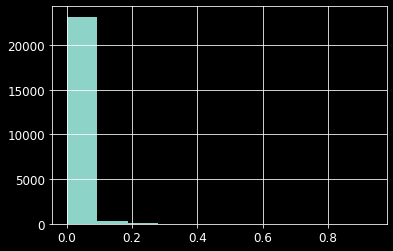

In [105]:
prob = pd.DataFrame(classifiers['LGBM'].predict_proba(X_test))
prob[prob[0] < 0.99].sort_values(by=prob.columns[1])[1].hist()


In [ ]:
prob[prob[0] < 0.95].sort_values(by=prob.columns[1])[1].hist()

In [ ]:
# health_raw = mne.io.read_raw_egi('/Users/rotemfalach/Downloads/MG4_sleep2_20190503_125004.mff')
health_raw = mne.io.read_raw_egi('C:\\PAT\\AH8_SLEEP_20201125_155835.mff')
# this is the  left set referenced to RM, while EOG referenced to LM
selected_set = [['E226', 'E46', 'E104', 'E35', 'E59', 'E116', 'E201'],
                ['EOG E1-LM', 'EOG E2-LM', 'LM', 'EEG F3-RM', 'EEG C3-RM', 'EEG O1-RM', 'RM']]
health_raw.pick_channels(selected_set[0]).resample(sr)
# order channels according to selected set, MNE default is alphabetical
health_raw.reorder_channels(selected_set[0])

# rename channels
health_raw.rename_channels({id: name for (id, name) in zip(selected_set[0], selected_set[1])})
# set EOG channels as MNE type "ecog" for re-refrencing
health_raw.set_channel_types({selected_set[1][i]: 'ecog' for i in range(2)})
# re-reference channels
health_raw.set_eeg_reference(ref_channels=[selected_set[1][2]], ch_type='ecog')
health_raw.set_channel_types({selected_set[1][i]: 'eog' for i in range(2)})
health_raw.drop_channels([selected_set[1][2], selected_set[1][6]])

In [178]:
health_raw

In [46]:
epochs = []
health_data = health_raw.pick_channels(['EOG E2-LM']).get_data()[0]
window_size = 250
for i in range(0, len(health_data), window_size):
    curr_block = health_data[i: i  + window_size]
    if i + window_size < len(health_data):
        epochs.append(curr_block)
epochs = np.array(epochs)

feat_healthy_eye = calc_features(epochs)
y_healthy_pred = classifiers['LGBM'].predict(feat_healthy_eye)

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


ValueError: Number of features of the model must match the input. Model n_features_ is 66 and input n_features is 63

In [ ]:
# i_pred = X_test[y_pred == 1].sort_values(by='epoch').index.tolist()
# i_pred.sort()
# for i in i_pred[:20]:
#     fig, axs = plt.subplots(3, figsize=(4, 4))
#     axs[0].set_title(i)
#     pred_view = np.concatenate(x_AH[i - 2: i + 3])
#     axs[0].plot(pred_view)
#     axs[0].plot(range(500, 750), x_AH[i], c='red')
#     pred_view = np.concatenate(x_bi[i - 2: i + 3])
#     axs[2].plot(pred_view)
#     axs[2].plot(range(500, 750), x_bi[i], c='black')
#     pred_view = np.concatenate(x_A[i - 2: i + 3])
#     axs[1].plot(pred_view)
#     axs[1].plot(range(500, 750), x_A[i], c='green')

In [25]:
def plt_80(cls, feat, y):
    all_col = feat.columns
    selector = VarianceThreshold(.1)
    selector.fit_transform(feat)
    feat = feat[feat.columns[selector.get_support(indices=True)]]
    X_train, X_test, y_train, y_test = train_test_split(feat, y, stratify=y, random_state=20)
    f, axes = plt.subplots(1, len(cls), figsize=(20, 5), sharey='row')

    for i, (key, classifier) in enumerate(cls.items()):
        y_pred = classifier.predict_proba(X_test).T
        cf_matrix = confusion_matrix(y_test, [p > 0.80 for p in y_pred[1]])
        metrics = get_metrics(cf_matrix)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i], xticks_rotation=45)
        text = """precision: {0}
                  recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
        axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                         xytext=(-60, -40), textcoords='offset points',
                         ha='right', va='top')
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i != 0:
            disp.ax_.set_ylabel('')

    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)

    f.colorbar(disp.im_, ax=axes)
    plt.show()

def plt_cls(feat, y):
    X_train, X_test, y_train, y_test = train_test_split(feat, y, stratify=y, random_state=20)
    X_train_data = X_train.iloc[:, 2:]
    selector = VarianceThreshold(.1)
    selector.fit_transform(X_train_data)
    X_train_data = X_train_data[X_train_data.columns[selector.get_support(indices=True)]]
    X_test_data = X_test[X_train_data.columns]

    classifiers_2_all = {
        "LGBM": LGBMClassifier(),
        "Random Forest": RandomForestClassifier(),
        # "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    }

    f, axes = plt.subplots(1, len(classifiers_2_all), figsize=(20, 5), sharey='row')

    for i, (key, classifier) in enumerate(classifiers_2_all.items()):
        y_pred = classifier.fit(X_train_data, y_train).predict(X_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
        metrics = get_metrics(cf_matrix)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i], xticks_rotation=45)
        text = """precision: {0}
                  recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
        axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                         xytext=(-60, -40), textcoords='offset points',
                         ha='right', va='top')
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i != 0:
            disp.ax_.set_ylabel('')
        pred_details = pd.DataFrame(data=X_test)
        pred_details['pred'] = y_pred

    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    plt.show()
    return classifiers_2_all, pred_details

def plot_specific(cls, feat, y_test, prob_80=False):
    f, axes = plt.subplots(1, len(cls), figsize=(20, 5), sharey='row')

    for i, (key, classifier) in enumerate(cls.items()):
        if prob_80:
            y_pred = classifier.predict_proba(feat).T
            cf_matrix = confusion_matrix(y_test, [p > 0.70 for p in y_pred[1]])
        else:
            y_pred = classifier.predict(feat)
            cf_matrix = confusion_matrix(y_test, y_pred)
        metrics = get_metrics(cf_matrix)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i], xticks_rotation=45)
        text = """precision: {0}
                  recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
        axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                         xytext=(-60, -40), textcoords='offset points',
                         ha='right', va='top')
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i != 0:
            disp.ax_.set_ylabel('')

    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)

    f.colorbar(disp.im_, ax=axes)
    plt.show()

In [51]:
feat_all_eog_bi = pd.concat([feat_all_eog1.add_suffix('_1'), feat_all_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)
feat_all_scalp_eog = pd.concat([feat_all_eog_bi, feat_all_scalp.iloc[:, 2:]], axis=1)

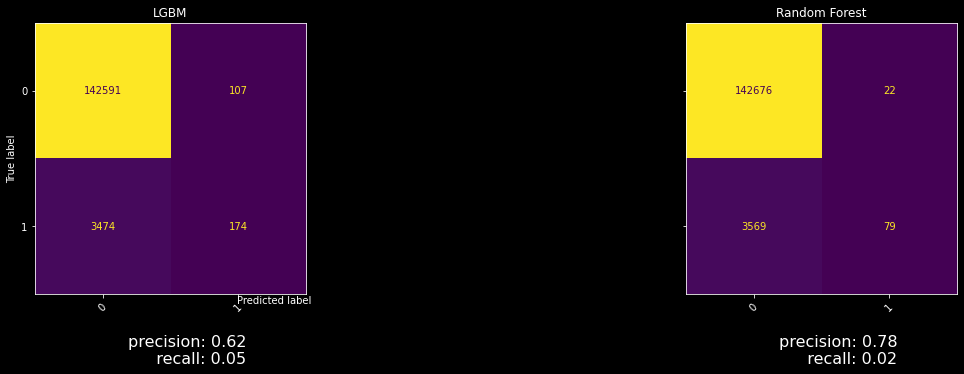

In [53]:
cls_all_scalp, pred_details_scalp = plt_cls(feat_all_scalp_eog, y_all_bi)

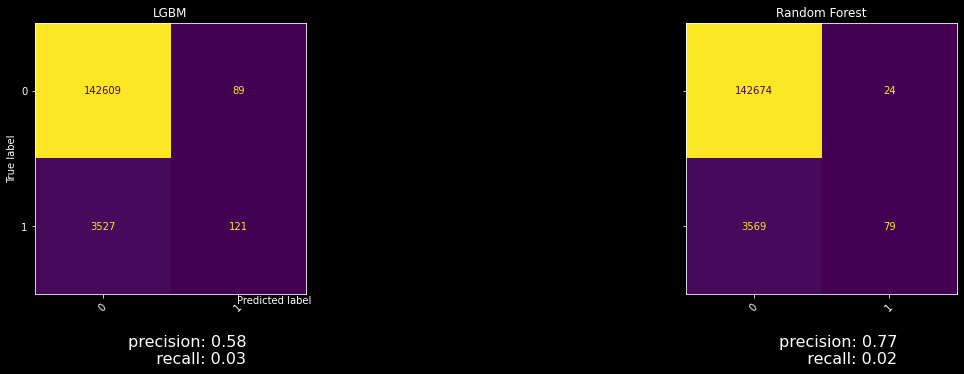

In [26]:
cls_all_bi, pred_details = plt_cls(feat_all_eog_bi, y_all_bi)

In [28]:
pred_details[pred_details['pred'] ==1]

,subj_1,epoch_id_1,std_1,iqr_1,skew_1,kurt_1,nzc_1,hmob_1,hcomp_1,theta_1,...,at_pmin_norm_2,gt_pmin_norm_2,ft_pmin_norm_2,ag_pmin_norm_2,af_pmin_norm_2,abspow_pmin_norm_2,perm_pmin_norm_2,higuchi_pmin_norm_2,petrosian_pmin_norm_2,pred
5361,406,5361,0.4549605337,0.5951617678,-0.9450212747,-0.4454708237,0,0.0446603313,3.4120172352,0.6015663324,...,-0.1904410763,-0.0716570832,-0.0881978823,-0.0806190382,-0.0976648849,3.4185373607,-0.4517125514,-0.2313308632,-0.3338260691,1.0
3178,406,3178,0.3316737432,0.2736490643,-1.2872717668,0.7107058267,2,0.0520487160,2.6464943703,0.4845418958,...,-0.0598171474,-0.0536486900,-0.0373427483,-0.0372524007,-0.0185141090,1.1405716067,-0.1234158141,-0.1372110071,-0.1767020992,1.0
91825,406,91825,0.2715854712,0.2571215447,-0.4885035727,0.3142941453,3,0.0522495511,3.1166812610,0.4621412428,...,-0.0686502781,-0.0740635414,-0.0768495234,-0.0745023535,-0.0732097053,0.7116330513,-0.5650544649,-0.5737211152,-0.4546103461,1.0
39154,406,39154,0.3404239239,0.6153190631,0.4801619535,-1.1284373275,2,0.0568217267,3.1561165814,0.6938892380,...,-0.2278223919,-0.0798686390,-0.0892859915,-0.0848480006,-0.0975082381,1.9265173929,-0.5722534459,-0.2618178629,-0.6493142147,1.0
45155,406,45155,0.2010758771,0.2547402880,-0.4145492757,-0.2060351908,2,0.0694553153,2.9135165152,0.4536003948,...,0.1474629151,0.1559640650,0.0508001171,0.1141280898,0.0374079674,0.5999397481,0.1132287665,0.0330512987,0.0595479154,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19123,406,19123,0.2321242578,0.3603764395,0.0780760571,-0.6990453129,3,0.0460621019,4.2535451477,0.5749989104,...,-0.0078026573,-0.0671632172,-0.0843387227,-0.0767539303,-0.0960518880,1.1066630707,-0.5650941562,-0.4340924352,-0.5902661739,1.0
6505,406,6505,0.2836390667,0.4488388534,-0.4711773670,-0.8806260422,0,0.0446008844,3.4537432536,0.5533688707,...,0.1176171557,-0.0547121177,-0.0579696153,-0.0550898422,-0.0528284081,2.1667207806,-0.9022073176,-0.5532669057,-0.6685681020,1.0
88781,406,88781,0.3714750248,0.5706236266,0.0795514606,-1.1719668852,2,0.0408113322,3.2625438933,0.7777821544,...,-0.2343035580,-0.0724362900,-0.0801262036,-0.0790481881,-0.0877884554,1.3852373033,-0.6962794524,-0.2316890412,-0.7695137556,1.0
34701,406,34701,0.5194836917,0.7515824134,0.3042715022,-0.8149400026,3,0.0426975414,2.9226376920,0.7753379373,...,-0.1762832249,-0.0767201267,-0.0853597255,-0.0801207192,-0.0902897364,3.4908177796,-0.4075376849,-0.3946631434,-0.4324340435,1.0


In [ ]:
pred_epochs = pred_details[(pred_details['subj'] == '402') & (pred_details['pred'] ==1 )].epoch_id.tolist()
pred_epochs.sort()

In [ ]:
plt_80(cls_all_bi, feat_all_eog1, y_all_bi)

In [ ]:
feat_all_eog_bi = pd.concat([feat_all_eog1.add_suffix('_1'), feat_all_eog2.add_suffix('_2')], axis=1)
normalized_df1=(feat_all_eog_bi-feat_all_eog_bi.mean())/feat_all_eog_bi.std()
cls_all_bi = plt_cls(normalized_df1, y_all_bi)

In [ ]:
plt_80(cls_all_bi, normalized_df1, y_all_bi)

In [ ]:
# this should run now
subj_out = '402'
feat_398_eog1 = get_all_feat_eog('1', [subj_out])
feat_398_eog2 = get_all_feat_eog('2', [subj_out])
feat_398_eog_bi = pd.concat([feat_398_eog1.add_suffix('_1'), feat_398_eog2.add_suffix('_2')], axis=1)
#normalized_398=(feat_398_eog_bi-feat_5_eog_bi.mean())/feat_5_eog_bi.std()
y_398_bi = get_all_y_multi_channel([subj_out])
clear_output()
cols = cls_all_bi["LGBM"].feature_name_
plot_specific(cls_all_bi, feat_398_eog_bi[cols], y_398_bi)

[19:25:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


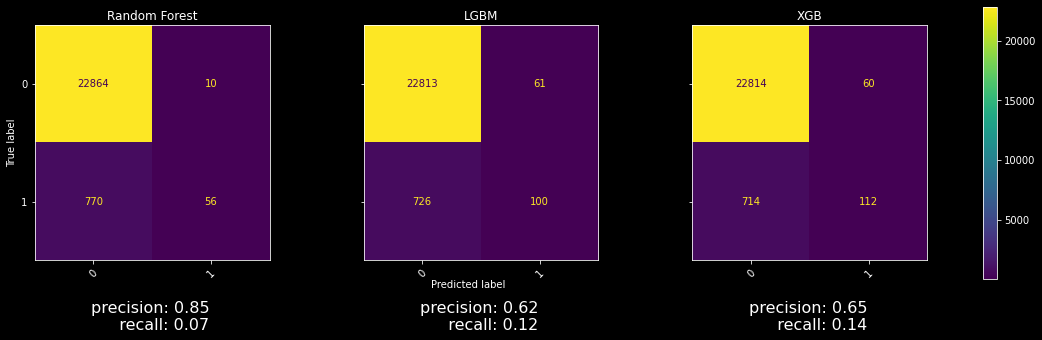

In [288]:
subj = '406'
y_bi_406 = get_all_y_multi_channel([subj])
# y_r = get_all_y_multi_channel_side('R', [subj])
# y_l = get_all_y_multi_channel_side('L', [subj])
feat_eog1_406 = get_all_feat_eog('1', [subj])
feat_eog2_406 = get_all_feat_eog('2', [subj])
feat_eog_bi_406 = pd.concat([feat_eog1_406.add_suffix('_1'), feat_eog2_406.add_suffix('_2')], axis=1)
clear_output()
cls_all_bi = plt_cls(feat_eog_bi_406, y_bi_406)

[14:13:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


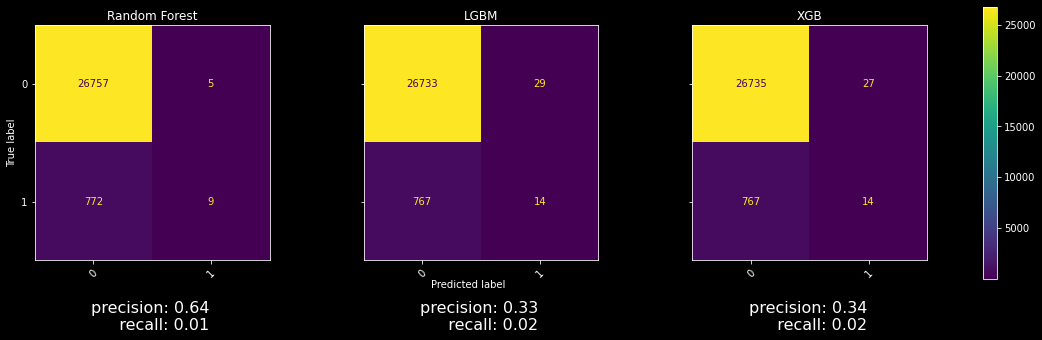

In [244]:
subj = '416'
y_bi_416 = get_all_y_multi_channel([subj])
# y_r = get_all_y_multi_channel_side('R', [subj])
# y_l = get_all_y_multi_channel_side('L', [subj])
feat_eog1_416 = get_all_feat_eog('1', [subj])
feat_eog2_416 = get_all_feat_eog('2', [subj])
feat_eog_bi_416 = pd.concat([feat_eog1_416.add_suffix('_1'), feat_eog2_416.add_suffix('_2')], axis=1)
clear_output()
cls_all_bi = plt_cls(feat_eog_bi_416, y_bi_416)

ipynb.fs.defs.yasa_model:90: RuntimeWarning: invalid value encountered in longlong_scalars
ipynb.fs.defs.yasa_model:94: RuntimeWarning: invalid value encountered in double_scalars


[14:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


ipynb.fs.defs.yasa_model:90: RuntimeWarning: invalid value encountered in longlong_scalars


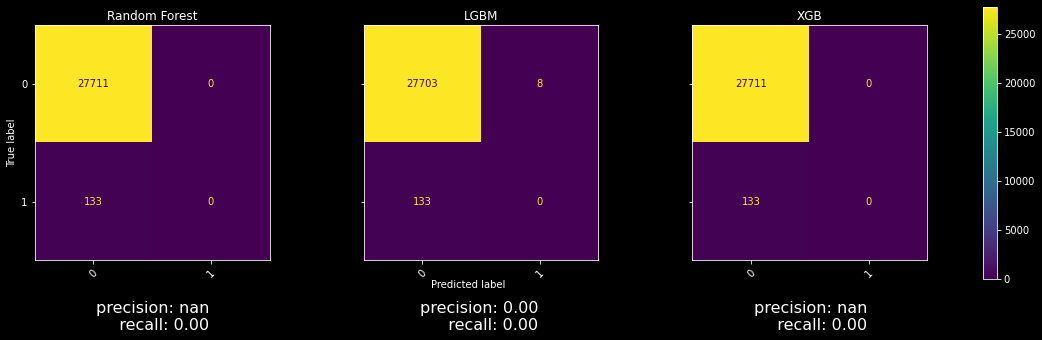

In [245]:
subj = '415'
y_bi_415 = get_all_y_multi_channel([subj])
# y_r = get_all_y_multi_channel_side('R', [subj])
# y_l = get_all_y_multi_channel_side('L', [subj])
feat_eog1_415 = get_all_feat_eog('1', [subj])
feat_eog2_415 = get_all_feat_eog('2', [subj])
feat_eog_bi_415 = pd.concat([feat_eog1_415.add_suffix('_1'), feat_eog2_415.add_suffix('_2')], axis=1)
clear_output()
cls_all_bi = plt_cls(feat_eog_bi_415, y_bi_415)

[14:32:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


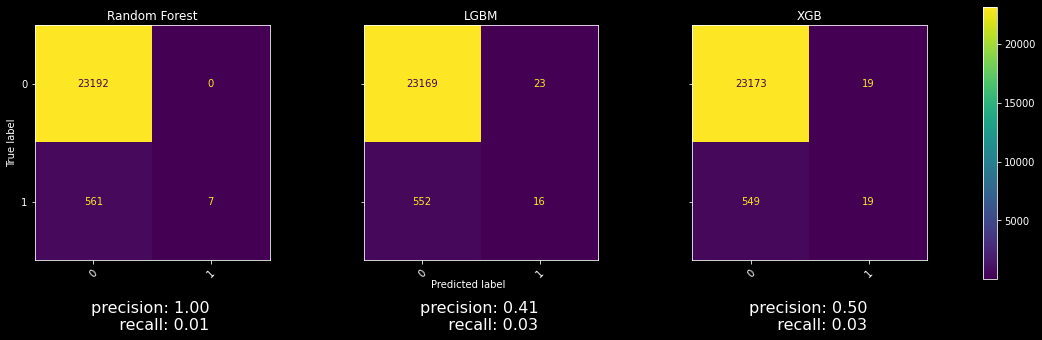

In [246]:
subj = '402'
y_bi_402 = get_all_y_multi_channel([subj])
feat_eog1_402 = get_all_feat_eog('1', [subj])
feat_eog2_402 = get_all_feat_eog('2', [subj])
feat_eog_bi_402 = pd.concat([feat_eog1_402.add_suffix('_1'), feat_eog2_402.add_suffix('_2')], axis=1)
clear_output()
cls_all_bi = plt_cls(feat_eog_bi_402, y_bi_402)

[14:59:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


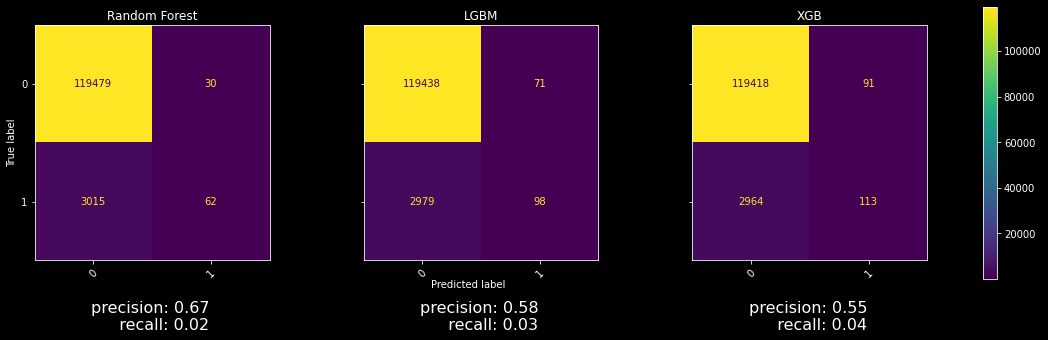

In [247]:
y_5_bi = get_all_y_multi_channel(['396', '398', '406', '415', '416'])
feat_5_eog1 = get_all_feat_eog('1', ['396', '398', '406', '415', '416'])
feat_5_eog2 = get_all_feat_eog('2', ['396', '398', '406', '415', '416'])
feat_5_eog_bi = pd.concat([feat_5_eog1.add_suffix('_1'), feat_5_eog2.add_suffix('_2')], axis=1)
clear_output()
cls_5_bi = plt_cls(feat_5_eog_bi, y_5_bi)

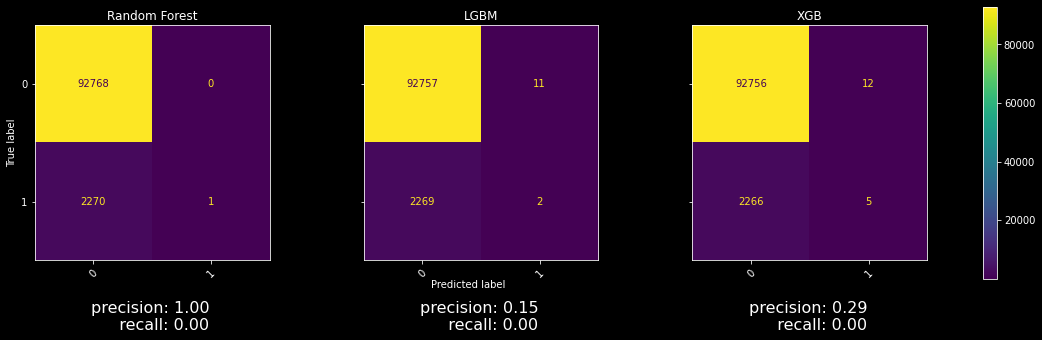

In [248]:
cols = cls_5_bi["LGBM"].feature_name_
plot_specific(cls_5_bi, feat_eog_bi_402[cols], y_bi_402)

In [ ]:
# plt_cls(feat_eog1, y_bi)
# plt_cls(feat_eog2, y_bi)
# plt_cls(feat_eog1, y_r)
# plt_cls(feat_eog1, y_l)
# plt_cls(feat_eog2, y_r)
# plt_cls(feat_eog2, y_l)

In [ ]:
# before calling to calc feat, per row/col, sub mean from all for center, minmax or z score, per channel or per epoch

In [258]:
# y_bi_402[y_bi_402 == 1]
spike_index_402 = np.transpose((y_bi_402 == 1).nonzero())

In [273]:
pd.DataFrame(spike_index_402).to_csv("spike_index_402.csv", header=False, index=False)

In [31]:
pred_details

,subj_1,epoch_id_1,std_1,iqr_1,skew_1,kurt_1,nzc_1,hmob_1,hcomp_1,theta_1,...,at_pmin_norm_2,gt_pmin_norm_2,ft_pmin_norm_2,ag_pmin_norm_2,af_pmin_norm_2,abspow_pmin_norm_2,perm_pmin_norm_2,higuchi_pmin_norm_2,petrosian_pmin_norm_2,pred
94612,402,94612,0.1598577278,0.2365153936,-0.4449407517,-0.9334180924,2,0.0519015734,6.3843982208,0.8404695504,...,-0.0793596426,-0.0405369700,-0.0578715910,-0.0457848959,-0.0527526860,-0.0904335864,0.2618391056,-0.0837624055,0.2907810374,0.0
47789,416,47789,0.1050529075,0.1151357223,-0.7795804799,0.5610882610,0,0.1086449113,3.3222454682,0.3488934926,...,0.1777879837,0.1280090140,0.0428967684,0.1414623172,0.0527745649,0.0573370378,-0.1938264491,-0.1708891678,-0.2347930496,0.0
60751,396,60751,0.1218587993,0.1244891876,-0.7173807946,-0.4070029866,7,0.0528527081,7.2594906949,0.6969713643,...,-0.1287434156,0.1727614025,0.1911786089,0.4450757346,0.4621451000,-0.1173978170,0.2469480691,0.6774944678,0.3192358904,0.0
33361,406,33361,0.6217029487,0.9669372648,0.3444516744,-0.9510133276,1,0.0158856582,13.7256449563,1.0546895603,...,-0.2001513992,-0.0398334813,-0.0116579525,-0.0089768847,0.0675541069,-0.1274648986,-0.0192226258,-0.2399457990,0.1182271582,0.0
59270,396,59270,0.1323592496,0.1697519094,0.0231084304,-0.6441281151,1,0.0517349639,6.2045092415,0.4274133703,...,0.0779029966,0.1542801221,0.0976650250,0.1127342191,0.0415339605,-0.0614388727,0.0145270561,0.1967108123,-0.0192217526,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73219,415,73219,0.6086359734,0.6797555738,-0.8343967321,-0.2041847516,2,0.0255607266,5.8535223831,0.9313786754,...,-0.3315154801,-0.0898479309,-0.1230297879,-0.0844683899,-0.1011489605,0.3791964310,-0.3523831034,-0.2778326519,-0.2785810013,0.0
98095,415,98095,0.1596663515,0.2231375442,0.1968566342,-0.3921840702,8,0.0960651406,3.3872669560,0.5187749780,...,0.1022567711,0.7880617354,0.3737535998,0.6541318727,0.3102273864,-0.0374519748,0.2793313723,0.5725198118,0.3025718684,0.0
48323,416,48323,0.0858405267,0.1352174643,0.0176103023,-0.7244023672,0,0.1240563556,3.0777043812,0.5004301111,...,0.3563051377,0.3248846170,0.3404981763,0.4945513606,0.4586480140,-0.0618806863,0.1817408697,0.1475416311,0.2343292925,0.0
76046,406,76046,0.1418692091,0.1996321201,-0.0971265661,-0.9632026236,6,0.0662903696,3.6980985893,0.5614031314,...,0.0751396712,-0.0014617875,-0.0262758990,-0.0117269261,-0.0423142406,-0.0173369632,0.0334631281,0.0217660343,-0.0196335715,0.0


In [44]:
pred_details[(pred_details['pred'] ==1 )].epoch_id_1

5361      5361
3178      3178
91825    91825
39154    39154
45155    45155
         ...  
19123    19123
6505      6505
88781    88781
34701    34701
44694    44694
Name: epoch_id_1, Length: 103, dtype: int32

In [ ]:
# save depth detection files
for subj in ['396', '398', '406', '415', '416']:
    y_bi = get_all_y_multi_channel([subj])
    spike_index = np.transpose((y_bi == 1).nonzero())
    pd.DataFrame(spike_index).to_csv(f"spike_index_{subj}.csv", header=False, index=False)

In [46]:
# save scalp detection files
for subj in ['402']:
    spike_index = pred_details[(pred_details['subj_1'] == subj) & (pred_details['pred'] ==1 )].epoch_id_1
    pd.DataFrame(spike_index).to_csv(f"scalp_index_{subj}.csv", header=False, index=False)

In [54]:
spike_index = pred_details[(pred_details['subj_1'] == '415') & (pred_details['pred'] ==1 )].epoch_id_1
pd.DataFrame(spike_index)

,epoch_id_1
111201,111201
